## Train a simple BDT reweighter

In [68]:
from src.learning.reweight import *
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
dfB = pd.read_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionB.csv", index_col=0)
dfA = pd.read_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionA.csv", index_col=0)
dfC = pd.read_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionC.csv", index_col=0)
dfD = pd.read_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionD.csv", index_col=0)

In [92]:
# select only TTbar to demonstrate reweighting
original = dfD[dfD.process=='TTbar']
target = dfC[dfC.process=='TTbar']

In [93]:
dropped = ['LHEReweightingWeight_values', 'Generator_weight_values', 'process', 'OS']
original = original.drop(columns=dropped)
target = target.drop(columns=dropped)

In [94]:
original_wgts = original['weight']
target_wgts = target['weight']
original.drop(columns=['weight'], inplace=True)
target.drop(columns=['weight'], inplace=True)
target.drop(columns=target.filter(like='BjetBYpt'), inplace=True)
original.drop(columns=original.filter(like='BjetBYpt'), inplace=True)

In [98]:
ori_train, ori_test, wo_train, wo_test = train_test_split(original, original_wgts)
tar_train, tar_test, wt_train, wt_test = train_test_split(target, target_wgts)

In [99]:
# train an xgb reweighter
reweighter = reweight.GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=1000, 
                                   gb_args={'subsample': 0.4})

In [100]:
reweighter.fit(ori_train, tar_train, wo_train, wt_train)

GBReweighter(gb_args={'subsample': 0.4}, learning_rate=0.1,
             min_samples_leaf=1000, n_estimators=50)

In [101]:
gb_weights_test = reweighter.predict_weights(ori_test)

In [102]:
tar_test.columns

Index(['LeadingTau_pt', 'LeadingTau_eta', 'LeadingTau_phi', 'LeadingTau_mass',
       'LeadingTau_dxy', 'LeadingTau_dz', 'LeadingTau_jetidx',
       'LeadingTau_charge', 'LeadingTau_idvsjet', 'LeadingTau_idvsmu',
       'LeadingTau_idvse', 'LeadingTau_genflav', 'SubleadingTau_pt',
       'SubleadingTau_eta', 'SubleadingTau_phi', 'SubleadingTau_mass',
       'SubleadingTau_dxy', 'SubleadingTau_dz', 'SubleadingTau_jetidx',
       'SubleadingTau_charge', 'SubleadingTau_idvsjet', 'SubleadingTau_idvsmu',
       'SubleadingTau_idvse', 'SubleadingTau_genflav', 'LDBjetBYtag_pt',
       'LDBjetBYtag_eta', 'LDBjetBYtag_phi', 'LDBjetBYtag_mass',
       'LDBjetBYtag_btag', 'LDBjetBYtag_jetid', 'SDBjetBYtag_pt',
       'SDBjetBYtag_eta', 'SDBjetBYtag_phi', 'SDBjetBYtag_mass',
       'SDBjetBYtag_btag', 'SDBjetBYtag_jetid', 'Tau_dR', 'Bjet_dR',
       'Tau_InvM', 'Bjet_InvM'],
      dtype='object')

KS over  Bjet_InvM  =  0.11750608243793126
KS over  Tau_dR  =  0.1134841429357949
KS over  LDBjetBYtag_mass  =  0.05373545109885092


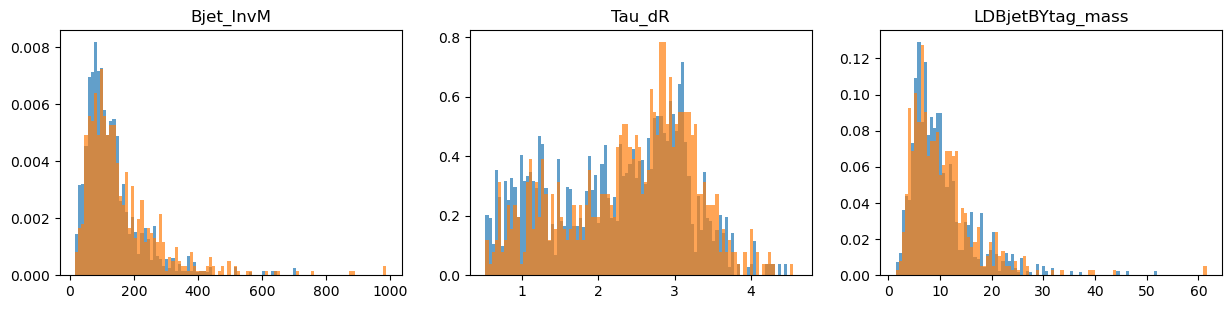

In [107]:
draw_distributions(ori_test, tar_test, wo_test, ['Bjet_InvM', 'Tau_dR', 'LDBjetBYtag_mass'])

KS over  Bjet_InvM  =  0.11237376564634782
KS over  Tau_dR  =  0.084684933483609
KS over  LDBjetBYtag_mass  =  0.05356516416997259


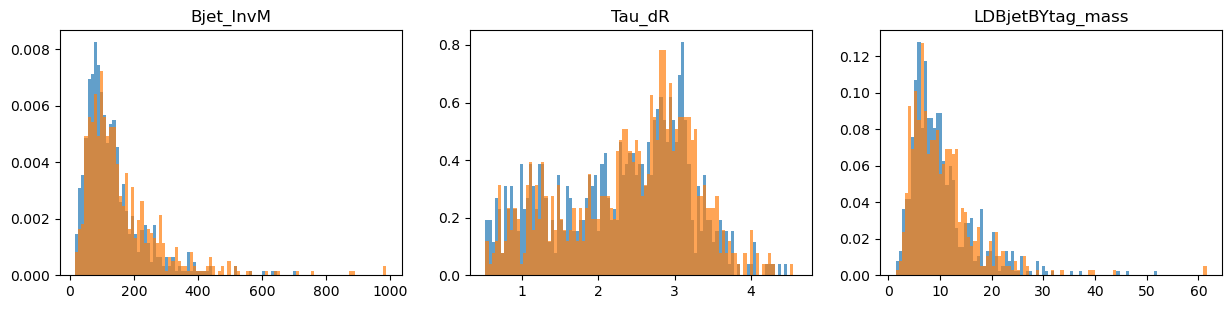

In [108]:
draw_distributions(ori_test, tar_test, gb_weights_test, ['Bjet_InvM', 'Tau_dR', 'LDBjetBYtag_mass'])

In [4]:
dl.data['OS'] = (dl.data['LeadingTau_charge'] * dl.data['SubleadingTau_charge'] < 0).astype(int) 

In [5]:
len(dl.data[dl.data['OS'] == 1])

60083

In [6]:
kept = ['pt', 'eta', 'mass', 'phi', 'dxy', 'dz', 'OS', 'process']
filtered = [col for col in dl.data.columns if any(k in col for k in kept)]
dl.data = dl.data[filtered]

In [7]:
signal = ['ZH', 'HH', 'ZZ']

In [8]:
bkgonly = dl.data[~dl.data['process'].isin(signal)]

In [9]:
dl.data = bkgonly
dl.data.drop(columns=['process'], inplace=True)

In [10]:
dl.target_column = 'OS'

In [11]:
dl.preprocess_data()
dl.split_data()

In [12]:
class_counts = torch.bincount(dl.y_train)
num_samples = len(dl.y_train)
class_weights = num_samples / (2.0 * class_counts.float())

In [13]:
scl = SimpleClassifier()
scl.criterion = nn.CrossEntropyLoss(weight=class_weights)

/Users/yuntongzhou/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
%load_ext autoreload
%autoreload 2

In [16]:
scl.evaluate(dl.X_test, dl.y_test.numpy())

Test Accuracy: 0.8240


/Users/yuntongzhou/Desktop/Dihiggszztt/HHtobbtautau/src/learning/classifier.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


In [17]:
len(dl.y_test)

18004

In [ ]:
dl.X_test[0]